In [42]:
import pandas as pd 
import numpy as np
import csv
import re
import string
from re import sub
from unidecode import unidecode

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords 
vector_dim = 50

#non-supvisé ne marche pas assez : je pense parce que la nature de nos données sont différent il n'y a pas de logique. 


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sabbar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [43]:
def text_to_word_list(text, remove_polish_letters):
    text = remove_polish_letters(text)
    text = str(text)
    text = text.lower()

    # Clean le text
    text = sub('(\d)([a-zA-Z]+)', r'\1 \2', text)
    text = sub(r"[^A-Za-z0-9^,!?.\/'+]", " ", text)
    text = sub(r"\+", " plus ", text)
    text = sub(r",", " ", text)
    text = sub(r"\.", " ", text)
    text = sub(r"!", " ! ", text)
    text = sub(r"\?", " ? ", text)
    text = sub(r"'", " ", text)
    text = sub(r":", " : ", text)
    text = sub(r'[!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~]', " ", text)
    text = sub(r"\s{2,}", " ", text)
    #text = text.split()

    return text

In [3]:
def cosine_similarity(x, y):
    
    # Compute the dot product between u and v (≈1 line)
    dot = np.dot(x,y)
    # Compute the L2 norm of u (≈1 line)
    norm_x = np.sqrt(np.sum(x**2))
    # Compute the L2 norm of v (≈1 line)
    norm_y = np.sqrt(np.sum(y**2))
    # Compute the cosine similarity defined by formula (1) (≈1 line)
    cosine_similarity = dot/(norm_x * norm_y)
    
    return cosine_similarity

In [6]:
df = pd.read_csv('../2-data/NETREAD.NETSOINS_TRANSMISSIONS-Tableau 1.csv', encoding='utf-8', sep=";")
df.libelle2 = df.libelle2.apply(lambda x: text_to_word_list(x, unidecode))
df.head(20)

,id_resident,id_etablissement,date_T,libelle2,Unnamed: 4
0,42973,557,1418663163,vue ce jour poursuite du suivi mme cautain est...,NaN
1,25134,739,1416909807,ai pose la question au dr touggani concernant ...,NaN
2,28144,561,1418664063,tres agrssive en ce moment surveillance sinon ...,NaN
3,16416,650,1421399533,reeducation de membre superieur gauche et de l...,NaN
4,10272,670,1418085149,elle n arrete pas de m appeler sur le telehone...,NaN
5,32249,754,1420373845,suite,NaN
6,17265,544,1419890663,soin collation nuit refus,NaN
7,2130,432,1419916286,fait surveillance sat 88 de sat 87 de puls et3...,NaN
8,653,368,1418134120,d jambe gauche oedematiee rouge a sa base avec...,NaN
9,23750,664,1421252017,me v a eu des selles liquides ce matin en gran...,NaN


In [7]:
df = df.head(10000)
df_2 = df[['libelle2']]
#df_2.columns = ['new']
df_2[df_2['libelle2'].str.strip().astype(bool)]
df_2.head()


,libelle2
0,vue ce jour poursuite du suivi mme cautain est...
1,ai pose la question au dr touggani concernant ...
2,tres agrssive en ce moment surveillance sinon ...
3,reeducation de membre superieur gauche et de l...
4,elle n arrete pas de m appeler sur le telehone...


In [8]:
stopwords_french = stopwords.words('french')
len(stopwords_french)

157

In [33]:
lst4 = []
for i in df_2.index:
    lst4 += df_2.libelle2.loc[i].split()

lst4[:10]

['vue',
 'ce',
 'jour',
 'poursuite',
 'du',
 'suivi',
 'mme',
 'cautain',
 'est',
 'peu']

In [34]:
df_2.to_csv('df_2_cleaned_dataset.csv', index=False)

In [35]:
len(lst4) * len(stopwords_french)

27664028

In [38]:
# Effectuer un prétraitement pour supprimer les signes de ponctuation et les stopwords (mots vides)
#[lst4.remove(i) for i in lst4 if i in string.punctuation]
[lst4.remove(i) for i in lst4 if i in stopwords_french]
lst4[:10]

['vue',
 'jour',
 'poursuite',
 'suivi',
 'mme',
 'cautain',
 'peu',
 'delirante',
 'jour',
 'parle']

In [46]:
series = pd.Series(lst4)
dic = {}

In [47]:
for index,word in enumerate(series.unique()):
    dic[word] = index 

In [48]:
# transformer le corpus en index correspondants pour fabriquer un dictionnaire
for i,j in enumerate(lst4):
    lst4[i] = dic[j]

In [49]:
from keras.preprocessing import sequence
from keras.layers import Input, Embedding, Dot, Reshape, Dense
from keras.models import Model

Using TensorFlow backend.


In [50]:
vocab_size = len(dic) + 1

In [51]:
sampling_table = sequence.make_sampling_table(vocab_size)

In [52]:
tuples, labels = sequence.skipgrams(lst4, vocab_size, window_size=4, sampling_table=sampling_table)

In [53]:
target_word, context_word = zip(*tuples)
word_target = np.array(target_word, dtype="int32")
word_context = np.array(context_word, dtype="int32")

In [54]:
embedding_matrix = np.zeros((vocab_size, vector_dim))

# correspondant à l'index de chaque ligne de matrice d'intégration, 
# remplissez les valeurs des intégrations de mots à 50 dimensions

for word,index in dic.items():
    try:
        embedding_matrix[index,:] = word_to_vec_map[word]
    except:
        continue # si le mot n'est pas présent dans les vecteurs GloVe, cette position d'index est déjà remplie 
                 # de zéros, comme nous l'avions initialisé.

In [55]:
# CONSTRUIRE LE MODÈLE KERAS 
input_target = Input((1,))
input_context = Input((1,))

# créer un Embedding de forme de embedding Keras (vocab_size, vector_dim) et définir l'argument 'trainable' sur 'True'
embedding = Embedding(input_dim = vocab_size, output_dim = vector_dim, input_length = 1, name='embedding', trainable = True)

# charger des données de pré-entraînés (embeddings) de la 'embedding_matrix' dans la couche embedding 
embedding.build((None,))
embedding.set_weights([embedding_matrix])

# Exécuter le contexte et cibler les mots à travers la couche embedding
context = embedding(input_context)
context = Reshape((vector_dim, 1))(context)

target = embedding(input_target)
target = Reshape((vector_dim, 1))(target)

Instructions for updating:
Colocations handled automatically by placer.


In [56]:
# calculer le produit scalaire du contexte et les mots cibles, pour trouver la similarité 

dot = Dot(axes = 1)([context, target]) 
dot = Reshape((1,))(dot)

# passer à travers un neurone d'activation «sigmoïde»; ceci est ensuite associé à la valeur de «label» générée à partir du skipgram

out = Dense(1, activation = 'sigmoid')(dot)

# créer une instance de modèle
model = Model(input = [input_context, input_target], output = out)
model.compile(loss = 'binary_crossentropy', metrics=['accuracy'], optimizer = 'adam') #, optimizer='rmsprop'
model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 50)        689650      input_2[0][0]                    
                                                                 input_1[0][0]                    
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 50, 1)        0           embedding[0][0]                  
__________

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  


In [57]:
# Lancer le model d'apprentissage  
model.fit(x = [word_target, word_context], y = labels, epochs = 5, batch_size =300) #


Instructions for updating:
Use tf.cast instead.
Epoch 1/5
560544/560544 [==============================] - 24s 42us/step - loss: 0.6932 - acc: 0.5000
Epoch 2/5
560544/560544 [==============================] - 24s 43us/step - loss: 0.6932 - acc: 0.5006
Epoch 3/5
560544/560544 [==============================] - 23s 41us/step - loss: 0.6932 - acc: 0.5004
Epoch 4/5
560544/560544 [==============================] - 23s 41us/step - loss: 0.6932 - acc: 0.5000
Epoch 5/5
560544/560544 [==============================] - 23s 41us/step - loss: 0.6932 - acc: 0.4995


In [58]:
word_vecs = model.layers[2].get_weights()[0]

In [59]:
df_2 = df_2.dropna()
df_2['new1_trained'] = 0
lst2 = []
for i in df_2.index:
    lst = []
    words = [j for j in df_2.libelle2.loc[i] if str(j).isalpha()] 
    #words = [j for j in words if not j in string.punctuation]
    words = [j for j in words if not j in stopwords_french]
    
    for word in words:
        try:
            lst.append(word_vecs[dic[word]])#nouvelles embeddings accessibles via l'index d'un mot en particulier dans 'dic'
        except:
            continue
    arr = np.array(lst)
    arrsum = arr.sum(axis = 0)
    if type(arrsum) != np.ndarray:
        arrsum = np.array([0] * vector_dim)
    else:    
        arrsum = arrsum/np.sqrt((arrsum**2).sum())
        
    lst2.append(arrsum)

# Pre-processing - text

In [61]:
import unicodedata
def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

remove_accented_chars('some accented letters â î or ô')

'some accented letters a i or o'

In [63]:
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-z0-9\s]' if not remove_digits else r'[^a-zA-z\s]'
    text = re.sub(pattern, '', text)
    return text

remove_special_characters("S0me sp3ci@l c#@4@c|3rs *&)@&)@#&", remove_digits=True)

'Sme spcil ccrs '

In [64]:
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/sabbar/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

# Regrouper mes mots 

In [66]:
df = pd.read_csv('../2-data/NETREAD.NETSOINS_TRANSMISSIONS-Tableau 1.csv', encoding='utf-8', sep=";")
df = df.head(2000)
df.libelle2 = df.libelle2.apply(lambda x: text_to_word_list(x, unidecode))
df_3 = [c for c in df.libelle2 if c.lower()[:4] != 'erreur']
df_3 = df[['libelle2']]
#df_2.columns = ['new']
df_3[df_3['libelle2'].str.strip().astype(bool)]
df_3.head()

,libelle2
0,vue ce jour poursuite du suivi mme cautain est...
1,ai pose la question au dr touggani concernant ...
2,tres agrssive en ce moment surveillance sinon ...
3,reeducation de membre superieur gauche et de l...
4,elle n arrete pas de m appeler sur le telehone...


In [67]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.9, max_features=200000,
                                 min_df=0.001, use_idf=True, ngram_range=(1,3))

%time 
tfidf_matrix = tfidf_vectorizer.fit_transform(df_3.iloc[0:2000,0]) #fit the vectorizer

print(tfidf_matrix.shape)

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs
(2000, 6320)


In [70]:
# obtenir les fonctionnalités impliquées
terms = tfidf_vectorizer.get_feature_names()

In [71]:
from sklearn.metrics.pairwise import cosine_similarity
dist = 1-cosine_similarity(tfidf_matrix)

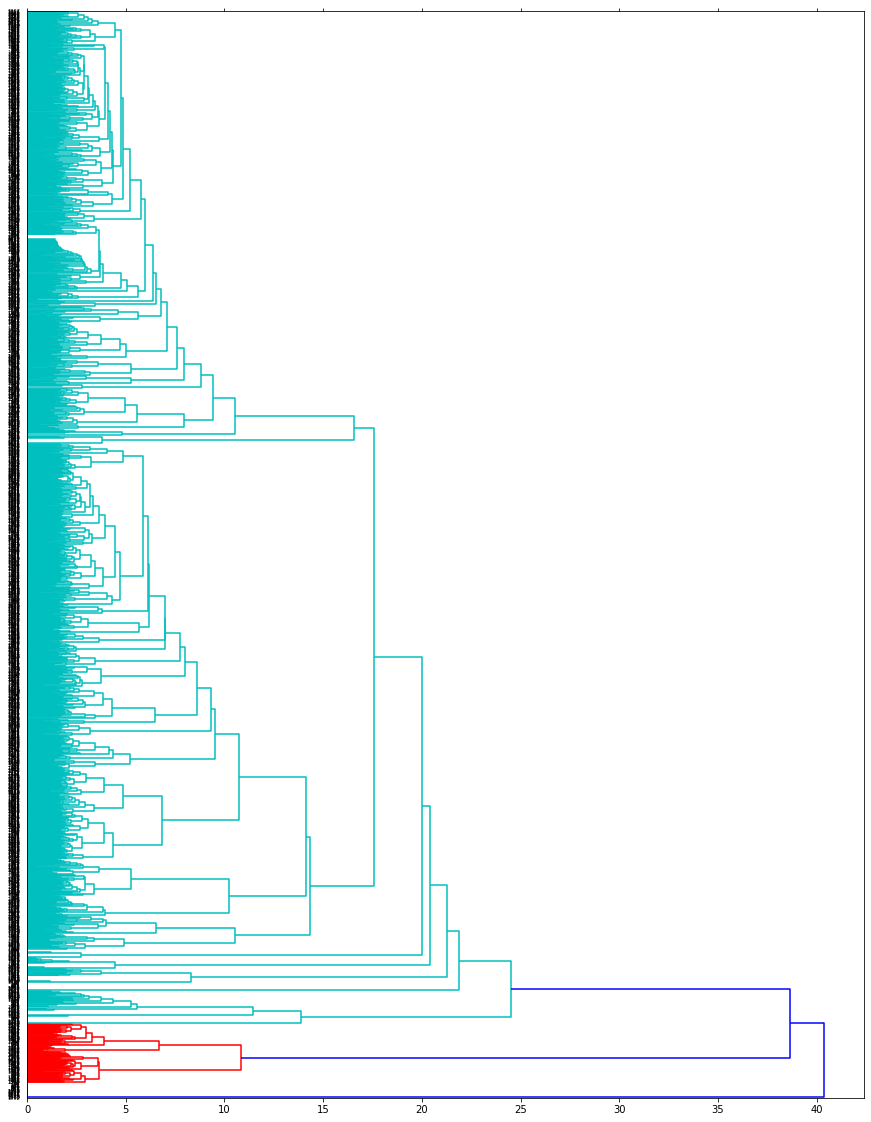

<Figure size 432x288 with 0 Axes>

In [77]:
# Tracer le dendrogramme 
from scipy.cluster.hierarchy import ward, dendrogram
import matplotlib.pyplot as plt

linkage_matrix = ward(dist) #définir la matrice de liaison en utilisant des distances précalculées de regroupement de quartiers

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right");

plt.tick_params(\
    axis= 'x',         
    which='both',      
    bottom='off',      
    top='off',         
    labelbottom='off')

plt.show() #afficher plot

# Enregistrer la figure en format png
plt.savefig('ward_clusters.png', dpi=200) #save figure

In [74]:
# classification de l'ensemble de données via le clustering 
from sklearn.cluster import AgglomerativeClustering
cluster=AgglomerativeClustering(n_clusters=6,affinity="euclidean",linkage="ward")
clust=cluster.fit_predict(tfidf_matrix.toarray())

In [83]:
from sklearn.cluster import KMeans

num_clusters = 6

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clust = km.labels_.tolist()

CPU times: user 21.7 s, sys: 1.42 s, total: 23.2 s
Wall time: 13.7 s


In [78]:
clust = pd.DataFrame(clust)
print(clust[0].unique())
len(clust)

[5 2 4 0 1 3]


2000

In [79]:
c1,c2,c3,c4,c5,c6= [],[],[],[],[],[]
for j,i in enumerate(clust):
    if(i==0):
        c1.append(df_3.iloc[j,0])
    elif(i==1):
        c2.append(df_3.iloc[j,0])
    elif(i==2):
        c3.append(df_3.iloc[j,0])
    elif(i==3):
        c4.append(df_3.iloc[j,0])
    elif(i==4):
        c5.append(df_3.iloc[j,0])
    elif(i==5):
        c6.append(df_3.iloc[j,0])

In [84]:
#c11 = c1.append(c2).append(c3).append(c4).append(c5).append(c6)
c1 = pd.DataFrame(c1, columns=['c1'])
c1['c2'] = pd.Series(c2)
c1['c3'] = pd.Series(c3)
c1['c4'] = pd.Series(c4)
c1['c5'] = pd.Series(c5)
c1['c6'] = pd.Series(c6)
c1.to_csv('groupe-c1.csv', sep=';', encoding='utf-8')